# Sentence classification by MorphConv
Implementation of [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882) to classify sentiment of movie review

### Explanation of this notebook
* Dataset : [Naver sentiment movie corpus v1.0](https://github.com/e9t/nsmc)
    + train, validation : splitting `ratings_train.txt` (150k reviews) for train (120k reviews) and validation (30k reviews)
    + test : `ratings_test.txt` (50k reviews)
* Preprocessing
    + Morphological analysis by Mecab wrapped by [konlpy](http://konlpy.org/en/latest/)

### Setup

In [1]:
import os
import sys

import numpy as np
np.random.seed(7)
import pandas as pd

from collections import Counter 

import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import (Input, Embedding, Conv1D, AveragePooling1D, 
                          concatenate, Bidirectional, GRU, Dense)
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from konlpy.tag import Mecab
import re

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


### Loading dataset

In [5]:
ratings_train = pd.read_csv('data/ratings_train.txt', sep = '\t')[['document', 'label']]
ratings_test = pd.read_csv('data/ratings_test.txt', sep = '\t')[['document', 'label']]

# ratings, ratings_tst의 document column에 nan 값이 있으므로 이를 빈 문자열로 대체
print(sum(ratings_train.document.isna()), sum(ratings_test.document.isna()))

ratings_train.document[ratings_train.document.isna()] = ''
ratings_test.document[ratings_test.document.isna()] = ''

print(sum(ratings_train.document.isna()), sum(ratings_test.document.isna()))

5 3
0 0


### Use mecab for preprocessing

In [87]:
def make_morphs(text):
    cleaned_text = re.sub('[^a-z|A-Z|가-힣|0-9|\,|\.|\!|\?]', ' ', text)
    cleaned_text = re.sub('(\!|\?){2,}', '\g<1>', cleaned_text)
    cleaned_text = cleaned_text.strip()
    base_words = mecab.morphs(cleaned_text)
    base_words = [word for word in base_words if '.' != word and ',' not in word]
    base_words = [word if '..' not in word else '...' for word in base_words]
    base_words = [word if word != '!' else '!!' for word in base_words]
    base_words = [word if word != '?' else '??' for word in base_words]

    
    sp_text = re.sub('[^ㅎㅎ|^^|ㅡㅡ|\-\-|~|;|♥|♡|★|ㅠ|ㅜ|ㅋ|ㅎ|ㅇ|ㅂ|ㅅ|ㅊ|ㅈ|ㄷ|ㄴ|ㅌ]', 
                     ' ', text)
    
    sp_text = re.sub('(ㅡ.ㅡ|-.-)', ' ㅡㅡ ', sp_text)
    sp_text = re.sub('(-|ㅡ){2,}', ' ㅡㅡ ', sp_text)
    sp_text = re.sub('(ㅋ|ㅎ|ㅇ|ㅂ|ㅅ|ㅊ|ㅈ|ㄷ|ㄴ|ㅌ){2,}', ' \g<1>\g<1> ', sp_text)
    sp_text = re.sub('(♥|♡)+', ' ♥♥ ', sp_text)
    sp_text = re.sub('(★|;|~)+', ' \g<1>\g<1> ', sp_text)
    sp_text = re.sub('\^+', ' ^^ ', sp_text)
    sp_text = re.sub('[ㅠ|ㅜ]+', ' ㅠㅠ ', sp_text)
    sp_text = re.sub('\s+', ' ', sp_text)
    sp_text = sp_text.strip()
    
    sp_words = sp_text.split(' ')
    sp_words = [word for word in sp_words if 'ㅡ' != word]
    
    result_text = base_words + sp_words if not '' in sp_words else base_words
    if not result_text:
        return ''
    
#     result_word = [word for word in result_word if len(word) > 1]
    result_words = '+'.join(result_text)
    return result_words

In [88]:
mecab = Mecab()

In [89]:
%%time
# train
print('Make train morphs......')
ratings_train['morphs'] = ratings_train['document'].apply(make_morphs)

# test
print('Make test morphs......')
ratings_test['morphs'] = ratings_test['document'].apply(make_morphs)

Make train morphs......
Make test morphs......
CPU times: user 31 s, sys: 151 ms, total: 31.2 s
Wall time: 31.6 s


In [90]:
ratings_train.to_csv('data/ratings_train_mecab_spword.txt', sep='\t', index=False)
ratings_test.to_csv('data/ratings_test_mecab_spword.txt', sep='\t', index=False)

### Reload data

In [2]:
ratings = pd.read_csv('data/ratings_train_mecab_spword.txt', sep = '\t')[['morphs', 'label']]
ratings_test = pd.read_csv('data/ratings_test_mecab_spword.txt', sep = '\t')[['morphs', 'label']]

# ratings, ratings_tst의 document column에 nan 값이 있으므로 이를 빈 문자열로 대체
print(sum(ratings.morphs.isna()), sum(ratings_test.morphs.isna()))

ratings.morphs[ratings.morphs.isna()] = ''
ratings_test.morphs[ratings_test.morphs.isna()] = ''

print(sum(ratings.morphs.isna()), sum(ratings_test.morphs.isna()))

167 56
0 0


### Preprocessing dataset

##### Find best random seed trought rasidual and varience

In [93]:
# print('Find best seed......')

# min_seed = 0
# min_residual = 100000000
# for i in tqdm(range(10000)):
#     x_data = ratings.morphs.apply(split_word).tolist()
#     y_data = ratings.label.tolist()

#     x_train_word, x_val_word, y_train, y_val = train_test_split(x_data, y_data,
#                                                                 test_size=0.2,
#                                                                 random_state=i,
#                                                                 stratify=y_data)
#     # print(len(y_train), sum(y_train), len(y_val), sum(y_val))

#     word_table = list(set([word for words in x_data for word in words]))
#     word_table = {word:0 for word in word_table}

#     train_counter = nlp.data.count_tokens(itertools.chain.from_iterable([c for c in x_train_word]))
#     train_table = word_table.copy()
#     train_table.update(train_counter)

#     val_counter = nlp.data.count_tokens(itertools.chain.from_iterable([c for c in x_val_word]))
#     val_table = word_table.copy()
#     val_table.update(val_counter)

#     train_cnt = np.array(list(train_table.values()))
#     val_cnt = np.array(list(val_table.values())) * 4
    
#     residual = np.abs(train_cnt-val_cnt).sum()
#     if residual < min_residual:
#         min_residual = residual
#         min_seed = i
#         print('seed:', i)
#         print(min_residual)
#         print(np.var(train_cnt), np.var(val_cnt))

Find best seed......


seed: 0
280028
73093.95535086525 72788.64036922259
seed: 4
279283
72659.20509965229 74530.59328873192
seed: 8
277420
72949.85140907383 73359.04609988058
seed: 108
276936
73050.30235850641 72953.05609298393
seed: 128
276021
73141.69375567777 72588.56850242332
seed: 267
275940
73197.65236750114 72370.5584639531
seed: 1069
275647
73067.3642571775 72884.91745579352
seed: 1395
275052
73194.207448039 72384.66283194325
seed: 4843
274889
73004.69947935347 73136.23770602426
seed: 5107
274502
73130.34417974179 72631.76975883021


### Make training data 

In [3]:
def split_word(text):
#     return text.split('+')
    return [word for word in text.split('+')]

In [4]:
print('Make train, val data......')

x_data = ratings.morphs.apply(split_word).tolist()
y_data = ratings.label.tolist()

x_train_word, x_val_word, y_train, y_val = train_test_split(x_data, y_data,
                                                            test_size=0.2,
                                                            random_state=349,
                                                            stratify=y_data)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

Make train, val data......


In [5]:
keywords = x_data

In [6]:
np.median([len(k) for k in keywords]), len(keywords)

(13.0, 150000)

In [7]:
keyword_cnt = Counter([i for item in keywords for i in item])

In [8]:
# keyword_clip_dict = dict(keyword_clip)
keyword_clip_dict = {key:value for key, value in keyword_cnt.items() if value >= 3}
keyword_dict = dict(zip(keyword_clip_dict.keys(), range(len(keyword_clip_dict))))

In [9]:
#공백과 미학습 단어 처리를 위한 사전 정보 추가
keyword_dict['_PAD_'] = len(keyword_dict)
keyword_dict['_UNK_'] = len(keyword_dict)

In [10]:
#리뷰 시퀀스 단어수의 중앙값 +10를 max 리뷰 시퀀스로 정함... 
# max_seq = np.median([len(k) for k in keywords]) + 10
max_seq = 20

In [11]:
def encoding_and_padding(corp_list, dic, max_seq=50):
    from keras.preprocessing.sequence import pad_sequences
    coding_seq = [ [dic.get(j, dic['_UNK_']) for j in i]  for i in corp_list ]
    #일반적으로 리뷰는 마지막 부분에 많은 정보를 포함할 가능성이 많아 패딩은 앞에 준다. 
    return(pad_sequences(coding_seq, maxlen=max_seq, padding='pre', truncating='pre',value=dic['_PAD_']))

In [12]:
x_train = encoding_and_padding(x_train_word, keyword_dict, max_seq=int(max_seq))
x_val = encoding_and_padding(x_val_word, keyword_dict, max_seq=int(max_seq))

In [13]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((120000, 20), (120000,), (30000, 20), (30000,))

### Define MorphConv class

In [53]:
inputs = Input(shape=(x_train.shape[1],), name='input')
embeddings_out = Embedding(input_dim=len(keyword_dict), 
                           output_dim=50,
                           name='embedding')(inputs)

conv0 = Conv1D(32, 1, padding='same')(embeddings_out)
conv1 = Conv1D(16, 2, padding='same')(embeddings_out)
conv2 = Conv1D(8, 3, padding='same')(embeddings_out)

pool0 = AveragePooling1D()(conv0)
pool1 = AveragePooling1D()(conv1)
pool2 = AveragePooling1D()(conv2)

concat_layer = concatenate([pool0, pool1, pool2],axis=2)

bidir = Bidirectional(GRU(10, recurrent_dropout=0.2, dropout=0.2))(concat_layer)

out = Dense(1,activation='sigmoid')(bidir)

model = Model(inputs=[inputs,], outputs=out)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 20)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 50)       1108400     input[0][0]                      
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 20, 32)       1632        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 20, 16)       1616        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_12 

### Training

In [54]:
# hyper-parameter
lr = 0.0003
epochs = 30 # 30
batch_size = 10000

In [55]:
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=['accuracy'])

# model.compile(loss='binary_crossentropy', 
#               optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
#               metrics=['accuracy'])

In [56]:
model_path = 'checkpoint/'
os.makedirs(model_path, exist_ok=True)
model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_acc", verbose=1, save_best_only=True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [57]:
hist = model.fit( x=x_train, y=y_train, 
                  batch_size=batch_size, epochs=epochs, 
                  validation_data=[x_val, y_val],
                  shuffle=True, callbacks = [checkpointer] )
#                  shuffle=True, callbacks = [checkpointer, early_stopping] )

Train on 120000 samples, validate on 30000 samples
Epoch 1/30
120000/120000 [==============================] - 4s 37us/step - loss: 0.6919 - acc: 0.5466 - val_loss: 0.6901 - val_acc: 0.6285

Epoch 00001: val_acc improved from -inf to 0.62853, saving model to checkpoint/01-0.6901.hdf5
Epoch 2/30
120000/120000 [==============================] - 1s 6us/step - loss: 0.6881 - acc: 0.6450 - val_loss: 0.6856 - val_acc: 0.6962

Epoch 00002: val_acc improved from 0.62853 to 0.69620, saving model to checkpoint/02-0.6856.hdf5
Epoch 3/30
120000/120000 [==============================] - 1s 6us/step - loss: 0.6821 - acc: 0.7065 - val_loss: 0.6780 - val_acc: 0.7234

Epoch 00003: val_acc improved from 0.69620 to 0.72343, saving model to checkpoint/03-0.6780.hdf5
Epoch 4/30
120000/120000 [==============================] - 1s 6us/step - loss: 0.6721 - acc: 0.7321 - val_loss: 0.6657 - val_acc: 0.7394

Epoch 00004: val_acc improved from 0.72343 to 0.73937, saving model to checkpoint/04-0.6657.hdf5
Epoch 5

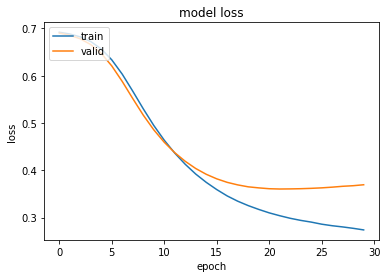

In [58]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Test

In [48]:
# Make test data
print('Make test data......')
x_test_word = ratings_test.morphs.apply(split_word).tolist()
x_test = encoding_and_padding(x_test_word, keyword_dict, max_seq=int(max_seq))
y_test = np.asarray(ratings_test.label.tolist())

Make test data......


In [49]:
x_test.shape, y_test.shape

((50000, 20), (50000,))

In [63]:
model_path = 'checkpoint/'
model = load_model(model_path+'22-0.3604.hdf5')

In [64]:
# prob = model.predict(x_test)

[loss, accuracy] = model.evaluate(x_test, y_test)
print('Loss:', loss, 'Accuracy:', accuracy)

50000/50000 [==============================] - 14s 284us/step
Loss: 0.36765167089939116 Accuracy: 0.8436


In [65]:
pred = model.predict(x_test)
test_f1_score = f1_score(y_test, pred > 0.5)
print('F1 Score:', test_f1_score)

F1 Score: 0.8436
